## Problem Statement
You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers. 
 

Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

## Goals

### Create the environment: 

You are given the ‘Env.py’ file with the basic code structure. This is the "environment class" - each method (function) of the class has a specific purpose. Please read the comments around each method carefully to understand what it is designed to do. Using this framework is not compulsory, you can create your own framework and functions as well.

### Build an agent that learns to pick the best request using DQN:

You can choose the hyperparameters (epsilon (decay rate), learning-rate, discount factor etc.) of your choice.

Training depends purely on the epsilon-function you choose. If the 
ϵ
 decays fast, it won’t let your model explore much and the Q-values will converge early but to suboptimal values. If 
ϵ
 decays slowly, your model will converge slowly. We recommend that you try converging the Q-values in 4-6 hrs.  We’ve created a sample 
ϵ
-decay function at the end of the Agent file (Jupyter notebook) that will converge your Q-values in ~5 hrs. Try building a similar one for your Q-network.

In the Agent file, we’ve provided the code skeleton. Using this structure is not necessary though.

           You have to submit your final DQN model as a pickle file as well.

### Convergence:

You need to converge your results. The Q-values may be suboptimal since the agent won't be able to explore much in 5-6 hours of simulation. But it is important that your Q-values converge. There are two ways to check the convergence of the DQN model:

Sample a few state-action pairs and plot their Q-values along episodes

Check whether the total rewards earned per episode are showing stability

          Showing one of these convergence plots will suffice.

## Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import math
import random
from itertools import permutations

# For building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
#from tensorflow.keras.optimizers import Adam

# For plotting graphs
import matplotlib.pyplot as plt


### 1. Load the Time Matrix

In [2]:
#import os
#from google.colab import drive
#drive.mount('/content/gdrive')

#google_drive_shared_path = os.path.join('/content/gdrive', 'MyDrive' ,'RL_assignment')
#print(google_drive_shared_path)# Loading the time matrix (part of the sample code)
Time_matrix = np.load("TM.npy")

### Check the max, min and mean time values required for defining the 'next_step' function in the Environment

In [3]:
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

11.0
0.0
3.0542857142857143
7.93705306122449


### Since the max time is 11 hours between any 2 points, the next state of the cab driver can only change by  1 day

### 2. Agent & Cab Driver Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify the hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.02
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.009
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state 
        q_value = self.model.predict(self.track_state)
        
        print("States_tracked value {0}.".format(q_value[0][2]))
        
        # Grab the q_value of the action index 
        self.states_tracked.append(q_value[0][2])
        
    def save(self, name):
        self.model.save(name)
        
# Defining hyperparameters
m = 5  # number of cities, ranges from 0 ..... m-1
t = 24  # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5  # Per hour fuel and other costs
R = 9  # per hour revenue from a passenger


class CabDriver():

    def __init__(self):
        """initialise your state and define your action space and state space"""
        self.action_space = [(0, 0)] + \
            list(permutations([i for i in range(m)], 2))
        self.state_space = [[x, y, z]
                            for x in range(m) for y in range(t) for z in range(d)]
        self.state_init = random.choice(self.state_space)
        #self.state_init = [0,0,0]
        # Start the first round
        self.reset()

    ## Encoding state (or state-action) for NN input

    def state_encod_arch1(self, state):
        """convert the state into a vector so that it can be fed to the NN. 
        This method converts a given state into a vector format. 
        Hint: The vector is of size m + t + d."""

        state_encod = [0 for _ in range(m+t+d)]
        state_encod[self.state_get_loc(state)] = 1
        state_encod[m+self.state_get_time(state)] = 1
        state_encod[m+t+self.state_get_day(state)] = 1

        return state_encod

    # Use this function if you are using architecture-2

    def state_encod_arch2(self, state, action):
        """convert the (state-action) into a vector so that it can be fed to the NN. 
        This method converts a given state-action pair into a vector format. 
        Hint: The vector is of size m + t + d + m + m."""
        state_encod = [0 for _ in range(m+t+d+m+m)]
        state_encod[self.state_get_loc(state)] = 1
        state_encod[m+self.state_get_time(state)] = 1
        state_encod[m+t+self.state_get_day(state)] = 1
        if (action[0] != 0):
            state_encod[m+t+d+self.action_get_pickup(action)] = 1
        if (action[1] != 0):
            state_encod[m+t+d+m+self.action_get_drop(action)] = 1

        return state_encod

    ## Getting number of requests

    def requests(self, state):
        """Determining the number of requests basis the location. 
        Use the table specified in the MDP and complete for rest of the locations"""
        location = state[0]
        if location == 0:
            requests = np.random.poisson(2)
        if location == 1:
            requests = np.random.poisson(12)
        if location == 2:
            requests = np.random.poisson(4)
        if location == 3:
            requests = np.random.poisson(7)
        if location == 4:
            requests = np.random.poisson(8)

        if requests > 15:
            requests = 15
        # (0,0) is not considered as customer request, however the driver is free to refuse all
        # customer requests. Hence, add the index of action (0,0).
        possible_actions_index = random.sample(range(1, (m-1)*m + 1), requests) + [0]
        actions = [self.action_space[i] for i in possible_actions_index]

        return possible_actions_index, actions

    def update_time_day(self, time, day, ride_duration):
        """
        Takes in the current state and time taken for driver's journey to return
        the state post that journey.
        """
        ride_duration = int(ride_duration)

        if (time + ride_duration) < 24:
            time = time + ride_duration
            # day is unchanged
        else:
            # duration taken spreads over to subsequent days
            # convert the time to 0-23 range
            time = (time + ride_duration) % 24 
            
            # Get the number of days
            num_days = (time + ride_duration) // 24
            
            # Convert the day to 0-6 range
            day = (day + num_days ) % 7

        return time, day
    
    def next_state_func(self, state, action, Time_matrix):
        """Takes state and action as input and returns next state"""
        next_state = []
        
        # Initialize various times
        total_time   = 0
        transit_time = 0    # to go from current  location to pickup location
        wait_time    = 0    # in case driver chooses to refuse all requests
        ride_time    = 0    # from Pick-up to drop
        
        # Derive the current location, time, day and request locations
        curr_loc = self.state_get_loc(state)
        pickup_loc = self.action_get_pickup(action)
        drop_loc = self.action_get_drop(action)
        curr_time = self.state_get_time(state)
        curr_day = self.state_get_day(state)
        """
         3 Scenarios: 
           a) Refuse all requests
           b) Driver is already at pick up point
           c) Driver is not at the pickup point.
        """    
        if ((pickup_loc== 0) and (drop_loc == 0)):
            # Refuse all requests, so wait time is 1 unit, next location is current location
            wait_time = 1
            next_loc = curr_loc
        elif (curr_loc == pickup_loc):
            # means driver is already at pickup point, wait and transit are both 0 then.
            ride_time = Time_matrix[curr_loc][drop_loc][curr_time][curr_day]
            
            # next location is the drop location
            next_loc = drop_loc
        else:
            # Driver is not at the pickup point, he needs to travel to pickup point first
            # time take to reach pickup point
            transit_time      = Time_matrix[curr_loc][pickup_loc][curr_time][curr_day]
            new_time, new_day = self.update_time_day(curr_time, curr_day, transit_time)
            
            # The driver is now at the pickup point
            # Time taken to drop the passenger
            ride_time = Time_matrix[pickup_loc][drop_loc][new_time][new_day]
            next_loc  = drop_loc

        # Calculate total time as sum of all durations
        total_time = (wait_time + transit_time + ride_time)
        next_time, next_day = self.update_time_day(curr_time, curr_day, total_time)
        
        # Construct next_state using the next_loc and the new time states.
        next_state = [next_loc, next_time, next_day]
        
        return next_state, wait_time, transit_time, ride_time
    

    def reset(self):
        """Return the current state and action space"""
        return self.action_space, self.state_space, self.state_init

    def reward_func(self, wait_time, transit_time, ride_time):
        """Takes in state, action and Time-matrix and returns the reward"""
        # transit and wait time yield no revenue, only battery costs, so they are idle times.
        passenger_time = ride_time
        idle_time      = wait_time + transit_time
        
        reward = (R * passenger_time) - (C * (passenger_time + idle_time))

        return reward

    def step(self, state, action, Time_matrix):
        """
        Take a trip as cabby to get rewards next step and total time spent
        """
        # Get the next state and the various time durations
        next_state, wait_time, transit_time, ride_time = self.next_state_func(
            state, action, Time_matrix)

        # Calculate the reward based on the different time durations
        rewards = self.reward_func(wait_time, transit_time, ride_time)
        total_time = wait_time + transit_time + ride_time
        
        return rewards, next_state, total_time

    def state_get_loc(self, state):
        return state[0]

    def state_get_time(self, state):
        return state[1]

    def state_get_day(self, state):
        return state[2]

    def action_get_pickup(self, action):
        return action[0]

    def action_get_drop(self, action):
        return action[1]

    def state_set_loc(self, state, loc):
        state[0] = loc

    def state_set_time(self, state, time):
        state[1] = time

    def state_set_day(self, state, day):
        state[2] = day

    def action_set_pickup(self, action, pickup):
        action[0] = pickup

    def action_set_drop(self, action, drop):
        action[1] = drop


### 3. DQN block

In [5]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 1000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### 4. Run the episodes, build up replay buffer and train the model.
### Note:
#### The moment total episode time exceeds 720 (30 days), we ignore the most recent ride and do NOT save that experience in the replay memory
#### The init state is randomly picked from the state space for each episode

In [6]:
start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    # Total time driver rode in this episode
    total_time = 0  
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipulated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="SuperCabs_car_model.h5")

    
elapsed_time = time.time() - start_time
print(elapsed_time)


Saving Model 0
States_tracked value 1469.4569091796875.
episode 9, reward -94.0, memory_length 1358, epsilon 0.9221844695076936 total_time 726.0
States_tracked value 148.27401733398438.
States_tracked value 201.91494750976562.
episode 19, reward -36.0, memory_length 2000, epsilon 0.8428131452558852 total_time 728.0
States_tracked value 311.64849853515625.
States_tracked value 409.7564697265625.
episode 29, reward -112.0, memory_length 2000, epsilon 0.770273216805883 total_time 726.0
States_tracked value 407.0257263183594.
States_tracked value 2108.215576171875.
episode 39, reward -81.0, memory_length 2000, epsilon 0.7039767140180825 total_time 724.0
States_tracked value 88.3470687866211.
States_tracked value 272.46099853515625.
episode 49, reward 235.0, memory_length 2000, epsilon 0.6433862726458905 total_time 725.0
States_tracked value 190.54171752929688.
States_tracked value 175.12356567382812.
episode 59, reward -183.0, memory_length 2000, epsilon 0.5880107787464963 total_time 725.0

States_tracked value 341.46514892578125.
episode 489, reward 1410.0, memory_length 2000, epsilon 0.012264946049102618 total_time 725.0
States_tracked value 356.1128845214844.
States_tracked value 394.24957275390625.
episode 499, reward 1387.0, memory_length 2000, epsilon 0.011209316679944023 total_time 727.0
States_tracked value 317.072021484375.
States_tracked value 360.4075927734375.
episode 509, reward 956.0, memory_length 2000, epsilon 0.010244544079381792 total_time 723.0
States_tracked value 355.8146667480469.
States_tracked value 991.331787109375.
episode 519, reward 267.0, memory_length 2000, epsilon 0.009362808313032746 total_time 730.0
States_tracked value 531.624755859375.
States_tracked value 319.97772216796875.
episode 529, reward 729.0, memory_length 2000, epsilon 0.008556962498997327 total_time 722.0
States_tracked value 237.21151733398438.
States_tracked value 256.9021301269531.
episode 539, reward 911.0, memory_length 2000, epsilon 0.007820474879030072 total_time 721.0

episode 959, reward 1540.0, memory_length 2000, epsilon 0.0001784842849617946 total_time 724.0
States_tracked value 350.6305847167969.
States_tracked value 374.0333557128906.
episode 969, reward 1390.0, memory_length 2000, epsilon 0.00016312235410742063 total_time 722.0
States_tracked value 352.7123718261719.
States_tracked value 381.27886962890625.
episode 979, reward 1584.0, memory_length 2000, epsilon 0.00014908260643362796 total_time 729.0
States_tracked value 366.5257873535156.
States_tracked value 338.46807861328125.
episode 989, reward 1092.0, memory_length 2000, epsilon 0.00013625124320120965 total_time 723.0
States_tracked value 323.2596740722656.
States_tracked value 452.6321105957031.
episode 999, reward 1297.0, memory_length 2000, epsilon 0.0001245242601935599 total_time 724.0
States_tracked value 375.8285217285156.
25578.383514881134


### The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720

### Save the tracked states 

In [9]:
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
save_obj(agent.states_tracked,"SuperCabs_model_weights")

### Tracking Convergence

In [11]:
agent.states_tracked

[1469.4569,
 148.27402,
 201.91495,
 311.6485,
 409.75647,
 407.02573,
 2108.2156,
 88.34707,
 272.461,
 190.54172,
 175.12357,
 171.36598,
 171.85172,
 164.1374,
 164.03802,
 171.59647,
 179.95253,
 159.63972,
 222.87624,
 217.88863,
 303.32034,
 540.34296,
 358.87857,
 367.02036,
 387.7605,
 818.2554,
 532.3041,
 1244.252,
 279.5982,
 94.27875,
 113.007416,
 154.71709,
 222.67564,
 263.61597,
 324.17813,
 326.6834,
 318.14307,
 312.12152,
 294.2769,
 317.40677,
 335.58777,
 299.47455,
 274.9882,
 307.78397,
 372.40268,
 353.29947,
 296.1079,
 337.47684,
 439.5971,
 413.82172,
 1101.37,
 375.7957,
 313.56592,
 320.24167,
 305.0534,
 353.52933,
 360.2735,
 375.32047,
 379.0484,
 371.18094,
 313.7961,
 364.21756,
 372.65768,
 354.859,
 353.3245,
 322.40674,
 3566.4014,
 823.40735,
 528.0614,
 442.9148,
 438.10886,
 431.95193,
 405.68228,
 377.53488,
 369.919,
 358.84406,
 331.63406,
 332.8695,
 339.21384,
 378.5627,
 412.5927,
 352.51547,
 269.23737,
 384.04178,
 19074.191,
 954.1812,
 

In [12]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### 5. Plot the Q-Value convergence for state action pairs

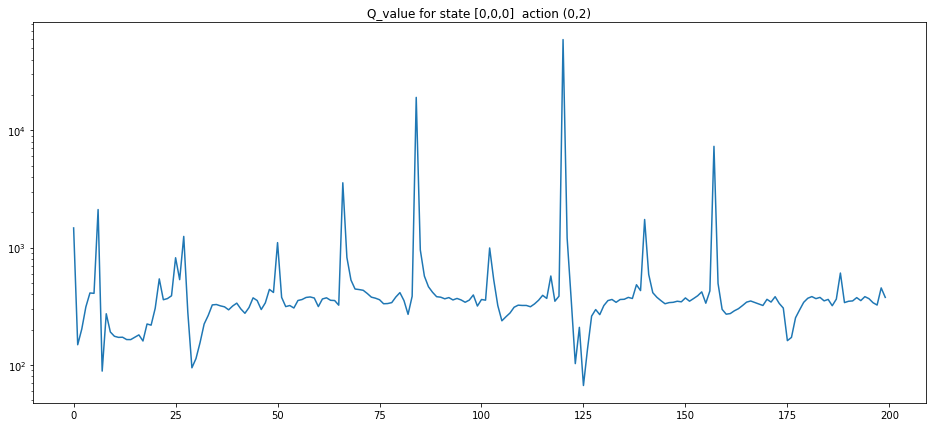

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Using log scale as the initial q_values are way too high compared to the steady state value (around 600)

### 6. Track rewards per episode.

In [15]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

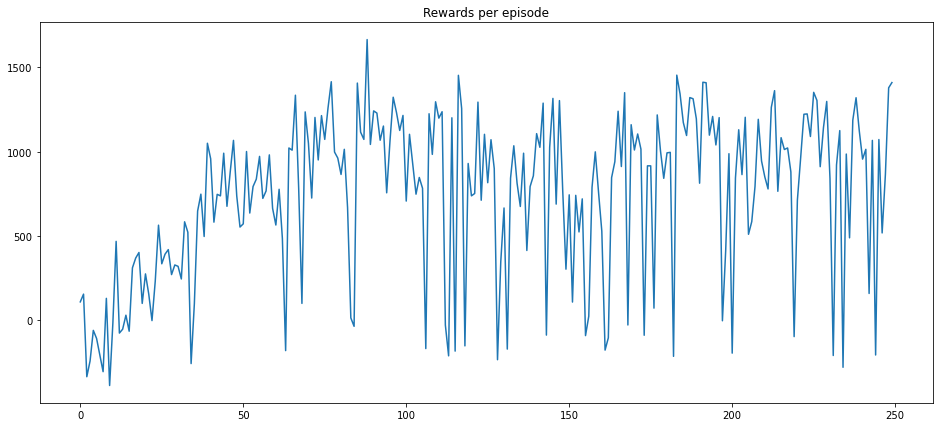

In [16]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

### We can see from the above plot that the rewards converge at around 1500. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.

#### Epsilon-decay sample function

In [17]:
import numpy as np
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

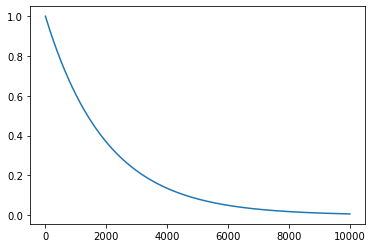

In [18]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()